In [354]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import random
import pdb
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import KFold
from datetime import datetime
import time

# implemetning stochastic gradient descent in Python

In [487]:
class Network(object):

    def __init__(self, sizes):
        """The sizes is a list.  it contains the number of neurons in the
        respective layers of the network.  For example, if the list
        was [2, 3, 1] then it would be a three-layer network, with the
        first layer containing 2 neurons, the second layer 3 neurons,
        and the third layer 1 neuron.  The biases and weights for the
        network are initialized randomly"""
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.cost_li = []
        self.biases = [np.random.randn(y, 1) 
                       for y in sizes[1:]] # randomly create bias vector of each node of each layer
        self.weights = [np.random.randn(y, x) 
                        for x, y in zip(sizes[:-1], sizes[1:])] # randomly create weights of each layer

    def feedforward(self, a):
        """Return the output of the network if ``a`` is input."""
        #pdb.set_trace()
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a)+b) # first muliply each node(activation from previous layer) with weights then add biases
        return a # new activation output

    def SGD(self, training_data, epochs, mini_batch_size, eta,test_data=None):
        """Train the neural network using mini-batch stochastic
        gradient descent.  The ``training_data`` is a list of tuples
        ``(x, y)`` representing the training inputs and the desiredoutputs."""
        if test_data: 
            n_test = len(test_data)
        n = len(training_data)
    
        #for each epoch
        for j in range(epochs):
            
            #collect cost, and accuracy of each epoch of testing data set
            #pdb.set_trace()
            cost_per_epoch = self.total_cost(training_data)
            if test_data:
                accuracy_test = self.predict(test_data)[0]/n_test
                accuracy_train = self.predict(training_data)[0]/n
                li = [j, mini_batch_size ,cost_per_epoch[0][0], eta, accuracy_test, accuracy_train]
                self.cost_li.append(li)
            
            #shuffle the data
            random.shuffle(training_data)       
            # create mini batch of the training data based on predefined mini_batch size
            mini_batches = [
                training_data[k:k+mini_batch_size] # training size of size k
                for k in range(0, n, mini_batch_size)] # loop through size n for every mini-size batch       
            # update weights and biases of the batch
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, eta)
              
            print("Epoch {0} complete, loss : {1}".format(j,cost_per_epoch))
                
    def update_mini_batch(self, mini_batch, eta):
        """Update the network's weights and biases by applying
        gradient descent using backpropagation to a batch.
        The mini_batch is a list of tuples (x, y), and eta
        is the learning rate."""
        # create empty matrix for new biases and weights
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        # loop through every data point in a batch
        for x, y in mini_batch:
            
            # backrpropagation :calculate derivative of cost function with respect of weights and biases
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            
            #collect deltas of each forward
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
            
        # update weights and biases 
        self.weights = [w-(eta/len(mini_batch))*nw
                        for w, nw in zip(self.weights, nabla_w)] #wl→wl−η/m∑δ*(al-1).T
        self.biases = [b-(eta/len(mini_batch))*nb
                       for b, nb in zip(self.biases, nabla_b)] #bl→bl−η/m∑xδx,l

    def backprop(self, x, y):
        """Return a tuple (nabla_b, nabla_w) representing the
        gradient for the cost function.  nabla_b and
        nabla_w are layer-by-layer lists of numpy arrays."""
        # create gradient empty matrix of bias and weights
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        
        # feedforward : sigmoid
        #pdb.set_trace()
        activation = x.reshape(8,1) # 8 x 1
        activations = [x.reshape(8,1)] # list to store all the activations in every layer
        zs = [] # list to store all the z vectors in every layer
        
        # calculate output using initialized/updated bias and weights
        for b, w in zip(self.biases, self.weights):
            #pdb.set_trace()
            z = np.dot(w, activation)+b # z=(wl*al−1+bl)
            zs.append(z)
            activation = sigmoid(z) # al=σ(z)
            activations.append(activation)
     
        # backward pass : start from the last layer
        delta = self.cost_derivative(activations[-1], y)*sigmoid_prime(zs[-1]) # derivative of output layer:δL=(aL−y)⊙σ′(zL)"
        nabla_b[-1] = delta # b = δL 
        nabla_w[-1] = np.dot(delta, activations[-2].transpose()) # ∂C/∂wljk=(aL−1k)*δL
        
        """l = 1 means the last layer of neurons, l = 2 is the second-last layer.
          Loop backwards from L-1 layer to calculate delta of each layer"""
        for l in range(2, self.num_layers):
            # pdb.set_trace()
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp # δl = ((wl+1).T *δl+1)⊙σ′(zl)
            nabla_b[-l] = delta # b = δl
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose()) #∂C/∂wljk = (al−1k)*(δlj)
            
        return (nabla_b, nabla_w)
    
    # cost for single data sample
    def cost_func(self, output_activations, y):
        c =(y- output_activations)**2
        return c
    
    # use MSE as cost function
    def total_cost(self, data):
        """Return the total cost for the training data set ``data``
        """
        cost = 0.0
        #loop over each data in training data set
        for x, y in data:
            a = self.feedforward(x.reshape(8,1))
            #pdb.set_trace()
            cost += self.cost_func(a, y) #sum up all the cost of each sample
        cost = cost/len(data) # calculate mean of the cost 
       
        return cost

    def predict(self, test_data):
        """Return the number of test inputs for which the neural
        network outputs the correct result. Note that the neural
        network's output is assumed to be the index of whichever
        neuron in the final layer has the highest activation."""
        #pdb.set_trace()
        test_results = [(np.round(self.feedforward(x.reshape(8,1))), y)
                        for (x, y) in test_data]
        return (sum(int(x == y) for (x, y) in test_results),test_results)
    
    def predict_prob(self, test_data):
        """Return the probabilities of each prediction"""
        #pdb.set_trace()
        test_results = [(self.feedforward(x.reshape(8,1)), y)
                        for (x, y) in test_data]
        return test_results

    def cost_derivative(self, output_activations, y):
        
        """Return the vector of partial derivatives of cost function,
        partial for the output activations."""
        
        return (output_activations-y)

# other functions
def sigmoid(z):
    """The sigmoid function."""
    return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z)*(1-sigmoid(z))

def loadData(filePath):
    """Load data and save as numpy array"""
    dataRaw = []
    labelsRaw = []
    DataFile = open(filePath)

    while True:
        theline = DataFile.readline()

        if len(theline) == 0:
            break

        theline = theline.rstrip()

        readData = theline.split(",")
        #appending variables
        for pos in range(len(readData)-1):
            readData[pos] = readData[pos]; 
        dataRaw.append(np.array(readData[0:8],'float64'))
        
        #appending target variables
        labelsRaw.append(np.array(readData[-1],'float64'))
        
    DataFile.close()
    data = dataRaw
    labels = labelsRaw

    return data, labels

def accuracy(pred, labels):
    """Input the predicted label and true label, it will return 
    accuracy, precision, recall, and f1 score."""
    tn, fp, fn, tp = confusion_matrix(labels, pred).ravel()
    accuray    = (tn+tp)/(tn+ fp +fn +tp)
    precision  = tp/(tp+fp) 
    recall     = tp/(tp+fn)
    f1         = (2*(precision*recall))/(precision+recall)

    return(round(accuray,3) ,round(precision,3), round(recall,3) , round(f1,3))

def zip_data(X_train, X_test, y_train, y_test):
    """Input is the splitted training and testing data,
    output will be """
    training_data = list(zip(X_train, y_train))
    test_data = list(zip(X_test, y_test))
    return(training_data,test_data)
                     

# neural network using Pytorch library

In [480]:
def nnTrain_batch(X, Y, batch_size, n_epochs, learning_rate, h= 60):
    training_Y = torch.tensor(Y, dtype = torch.float32)
    training_X = torch.from_numpy(X)
    loss_li=[]
    
    model = torch.nn.Sequential(
        torch.nn.Linear(8,h),
        torch.nn.Sigmoid(),
        torch.nn.Linear(h,1),
        torch.nn.Sigmoid(),
    )
    # define loss function
    loss_fn = torch.nn.MSELoss(reduction = 'mean')
    learning_rate = learning_rate
    n_epochs = n_epochs
    
    #training model in mini batch
    for t in range(n_epochs):
        
        np.random.shuffle(X)        
        current_batch = 0   
        for iteration in range(len(Y) // batch_size):
            # split batch
            #pdb.set_trace()
            batch_x = X[current_batch: current_batch + batch_size]
            batch_y = Y[current_batch: current_batch + batch_size]
            current_batch += batch_size
            # convert data type
            batch_tensor_y = torch.tensor(batch_y, dtype = torch.float32)
            batch_tensor_x = torch.from_numpy(batch_x)

            y_pred = model(batch_tensor_x)
            
            # input is the second value or pred : probability of class 2
            loss = loss_fn(y_pred, batch_tensor_y)
            #print(t, loss.item())
            model.zero_grad()
            loss.backward()
        print("epoch: ", t," finish")
            
        #calculate loss per epoch
        loss_per_epoch = loss_fn(model(training_X), training_Y)
        loss_li.append(loss_per_epoch)
        
        #back proprogation
        with torch.no_grad():
            for param in model.parameters():
                param -= learning_rate*param.grad
                
    return model,loss_li


# Load Data

In [449]:
data,labels = loadData("HTRU_2.csv")
print("all data size:",len(data))

#split data to training and testing data
X_train, X_test, y_train, y_test = train_test_split(data, labels , test_size=0.2)

#convert data into tuple
training_inputs = [x for x in X_train]
training_data = list(zip(X_train, y_train))
test_data = list(zip(X_test, y_test))

all data size: 17898


# implemented NN : test the code 

In [485]:
#training
start=datetime.now()
net = Network([8, 10, 1])
net.SGD(training_data, 10, 100, 0.05, test_data=test_data) # epochs, batch_size, learning rate
print ("training compute time ", (datetime.now()-start).total_seconds())

#validation
accurate,results = net.predict(test_data)
print("{0}/ {1}, accuracy :{2}".format(accurate,len(test_data), accurate/ len(test_data)))
results_unnest = [(int(x[0][0]), int(y)) for (x,y) in results]
results_df = pd.DataFrame(results_unnest) # pred, y
accuracy_test ,precision, recall ,f1 =  accuracy(results_df[0], results_df[1]) # pred, y
print("accuracy:",accuracy_test , ", precision: ",precision,", recall:", recall, ",f1:", f1)

#cost
print(net.cost_li)

Epoch 0 complete
Epoch 1 complete
Epoch 2 complete
Epoch 3 complete
Epoch 4 complete
Epoch 5 complete
Epoch 6 complete
Epoch 7 complete
Epoch 8 complete
Epoch 9 complete
training compute time  0.008598
1/ 2, accuracy :0.5
accuracy: 0.5 , precision:  0.5 , recall: 1.0 ,f1: 0.667
[[0, 100, 0.4940668160873278, 0.05, 0.5, 0.5], [1, 100, 0.49405959847111497, 0.05, 0.5, 0.5], [2, 100, 0.4940523643211362, 0.05, 0.5, 0.5], [3, 100, 0.49404511358185216, 0.05, 0.5, 0.5], [4, 100, 0.49403784619747687, 0.05, 0.5, 0.5], [5, 100, 0.4940305621119777, 0.05, 0.5, 0.5], [6, 100, 0.4940232612690724, 0.05, 0.5, 0.5], [7, 100, 0.4940159436122289, 0.05, 0.5, 0.5], [8, 100, 0.49400860908466343, 0.05, 0.5, 0.5], [9, 100, 0.4940012576293395, 0.05, 0.5, 0.5]]


# Pytorch : training and testing code

epoch:  0  finish
epoch:  1  finish
epoch:  2  finish
epoch:  3  finish
epoch:  4  finish
epoch:  5  finish
epoch:  6  finish
epoch:  7  finish
epoch:  8  finish
epoch:  9  finish
training compute time  4.341415
tensor([0.]) tensor([0.1527])
tensor([0.]) tensor([0.1280])
tensor([0.]) tensor([0.1535])
tensor([0.]) tensor([0.1650])
tensor([0.]) tensor([0.1623])
tensor([0.]) tensor([0.1475])
tensor([0.]) tensor([0.1646])
tensor([0.]) tensor([0.1460])
tensor([0.]) tensor([0.1267])
tensor([0.]) tensor([0.1500])
tensor([0.]) tensor([0.1295])
tensor([0.]) tensor([0.1266])
tensor([0.]) tensor([0.1484])
tensor([0.]) tensor([0.3052])
tensor([0.]) tensor([0.1448])
tensor([0.]) tensor([0.1988])
tensor([0.]) tensor([0.1576])
tensor([0.]) tensor([0.1476])
tensor([0.]) tensor([0.1638])
tensor([0.]) tensor([0.1497])
tensor([0.]) tensor([0.1498])
tensor([0.]) tensor([0.1279])
tensor([0.]) tensor([0.1396])
tensor([0.]) tensor([0.1266])
tensor([0.]) tensor([0.1411])
tensor([0.]) tensor([0.2059])
tensor([

tensor([0.]) tensor([0.3066])
tensor([0.]) tensor([0.1360])
tensor([0.]) tensor([0.1538])
tensor([0.]) tensor([0.1570])
tensor([0.]) tensor([0.2890])
tensor([0.]) tensor([0.1432])
tensor([0.]) tensor([0.2813])
tensor([0.]) tensor([0.1895])
tensor([0.]) tensor([0.1827])
tensor([0.]) tensor([0.1356])
tensor([0.]) tensor([0.1530])
tensor([0.]) tensor([0.1265])
tensor([0.]) tensor([0.2309])
tensor([0.]) tensor([0.1369])
tensor([0.]) tensor([0.1423])
tensor([0.]) tensor([0.1431])
tensor([0.]) tensor([0.1266])
tensor([0.]) tensor([0.1381])
tensor([0.]) tensor([0.1261])
tensor([0.]) tensor([0.2421])
tensor([0.]) tensor([0.2764])
tensor([0.]) tensor([0.1470])
tensor([0.]) tensor([0.1396])
tensor([0.]) tensor([0.1266])
tensor([0.]) tensor([0.1507])
tensor([0.]) tensor([0.1544])
tensor([0.]) tensor([0.1569])
tensor([0.]) tensor([0.1407])
tensor([0.]) tensor([0.1588])
tensor([0.]) tensor([0.1361])
tensor([0.]) tensor([0.1753])
tensor([0.]) tensor([0.1559])
tensor([0.]) tensor([0.1539])
tensor([0.

tensor([0.]) tensor([0.1394])
tensor([0.]) tensor([0.1640])
tensor([0.]) tensor([0.1266])
tensor([0.]) tensor([0.2171])
tensor([0.]) tensor([0.1889])
tensor([0.]) tensor([0.2472])
tensor([0.]) tensor([0.1923])
tensor([0.]) tensor([0.1282])
tensor([0.]) tensor([0.1266])
tensor([0.]) tensor([0.3444])
tensor([0.]) tensor([0.1445])
tensor([0.]) tensor([0.1312])
tensor([0.]) tensor([0.1266])
tensor([0.]) tensor([0.1369])
tensor([0.]) tensor([0.1464])
tensor([0.]) tensor([0.1631])
tensor([0.]) tensor([0.1548])
tensor([0.]) tensor([0.1328])
tensor([0.]) tensor([0.1593])
tensor([0.]) tensor([0.2748])
tensor([0.]) tensor([0.1640])
tensor([0.]) tensor([0.1833])
tensor([0.]) tensor([0.1269])
tensor([0.]) tensor([0.2106])
tensor([0.]) tensor([0.1822])
tensor([0.]) tensor([0.1266])
tensor([0.]) tensor([0.1411])
tensor([0.]) tensor([0.3031])
tensor([0.]) tensor([0.1634])
tensor([0.]) tensor([0.1402])
tensor([0.]) tensor([0.1404])
tensor([0.]) tensor([0.1273])
tensor([0.]) tensor([0.1266])
tensor([0.

tensor([0.]) tensor([0.1272])
tensor([0.]) tensor([0.1514])
tensor([0.]) tensor([0.1545])
tensor([0.]) tensor([0.1387])
tensor([0.]) tensor([0.1938])
tensor([0.]) tensor([0.1446])
tensor([0.]) tensor([0.2958])
tensor([0.]) tensor([0.1498])
tensor([0.]) tensor([0.1371])
tensor([0.]) tensor([0.1266])
tensor([0.]) tensor([0.1341])
tensor([0.]) tensor([0.2575])
tensor([0.]) tensor([0.2978])
tensor([0.]) tensor([0.3130])
tensor([0.]) tensor([0.1369])
tensor([0.]) tensor([0.1379])
tensor([0.]) tensor([0.1379])
tensor([0.]) tensor([0.1429])
tensor([0.]) tensor([0.1415])
tensor([0.]) tensor([0.1489])
tensor([0.]) tensor([0.1417])
tensor([0.]) tensor([0.1476])
tensor([0.]) tensor([0.1397])
tensor([0.]) tensor([0.2991])
tensor([0.]) tensor([0.1333])
tensor([0.]) tensor([0.1589])
tensor([0.]) tensor([0.1266])
tensor([0.]) tensor([0.1434])
tensor([0.]) tensor([0.1631])
tensor([0.]) tensor([0.2294])
tensor([0.]) tensor([0.1998])
tensor([0.]) tensor([0.1502])
tensor([0.]) tensor([0.1380])
tensor([0.

tensor([0.]) tensor([0.2125])
tensor([0.]) tensor([0.1391])
tensor([0.]) tensor([0.1483])
tensor([0.]) tensor([0.1400])
tensor([0.]) tensor([0.1693])
tensor([0.]) tensor([0.1618])
tensor([0.]) tensor([0.1434])
tensor([0.]) tensor([0.1531])
tensor([0.]) tensor([0.2190])
tensor([0.]) tensor([0.1446])
tensor([0.]) tensor([0.1375])
tensor([0.]) tensor([0.1571])
tensor([0.]) tensor([0.1377])
tensor([0.]) tensor([0.1277])
tensor([0.]) tensor([0.1488])
tensor([0.]) tensor([0.1280])
tensor([0.]) tensor([0.1269])
tensor([0.]) tensor([0.1266])
tensor([0.]) tensor([0.2105])
tensor([0.]) tensor([0.1367])
tensor([0.]) tensor([0.1449])
tensor([0.]) tensor([0.1429])
tensor([0.]) tensor([0.1425])
tensor([0.]) tensor([0.1291])
tensor([0.]) tensor([0.1278])
tensor([0.]) tensor([0.2373])
tensor([0.]) tensor([0.1299])
tensor([0.]) tensor([0.1262])
tensor([0.]) tensor([0.1446])
tensor([0.]) tensor([0.1499])
tensor([0.]) tensor([0.1476])
tensor([0.]) tensor([0.1266])
tensor([0.]) tensor([0.1635])
tensor([0.

tensor([0.]) tensor([0.1379])
tensor([0.]) tensor([0.1430])
tensor([0.]) tensor([0.1345])
tensor([0.]) tensor([0.1478])
tensor([0.]) tensor([0.1621])
tensor([0.]) tensor([0.1561])
tensor([0.]) tensor([0.1278])
tensor([0.]) tensor([0.1376])
tensor([0.]) tensor([0.1319])
tensor([0.]) tensor([0.1564])
tensor([0.]) tensor([0.1463])
tensor([0.]) tensor([0.1289])
tensor([0.]) tensor([0.1418])
tensor([0.]) tensor([0.1269])
tensor([0.]) tensor([0.1525])
tensor([0.]) tensor([0.1266])
tensor([0.]) tensor([0.1266])
tensor([0.]) tensor([0.1395])
tensor([0.]) tensor([0.1385])
tensor([0.]) tensor([0.1388])
tensor([0.]) tensor([0.1517])
tensor([0.]) tensor([0.1380])
tensor([0.]) tensor([0.1459])
tensor([0.]) tensor([0.1265])
tensor([0.]) tensor([0.1333])
tensor([0.]) tensor([0.1426])
tensor([0.]) tensor([0.1409])
tensor([0.]) tensor([0.1423])
tensor([0.]) tensor([0.1497])
tensor([0.]) tensor([0.1266])
tensor([0.]) tensor([0.1552])
tensor([0.]) tensor([0.1380])
tensor([0.]) tensor([0.1266])
tensor([0.

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:209: RuntimeWarning: invalid value encountered in long_scalars


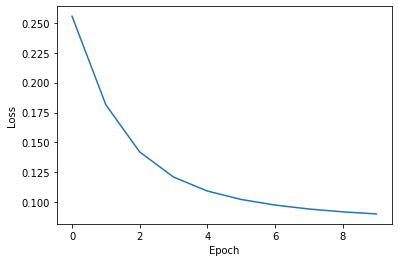

In [458]:
# pre-processing of input data
predictions = []
x_train_torch = pd.DataFrame(X_train)
y_train_torch = [int(i) for i in y_train]

#training model
start=datetime.now()
model,loss_li = nnTrain_batch(np.array(x_train_torch,dtype='float32'), y_train_torch,256, 10, 0.05)  #X, Y, batch_size, n_epochs, learning_rate
print ("training compute time ", (datetime.now()-start).total_seconds())

#testing set validation
for i,item in enumerate(np.array(X_test)):
    
    item = np.array(item,dtype='float32')
    with torch.no_grad():
        prediction = model(torch.from_numpy(item))
        print(np.round(prediction), prediction)
        
    # the predicted label is the one has higher probability  
    predictions.append(np.round(prediction))
  
            
print("NN Predicttion:",accuracy(y_test, predictions)) #accuray ,precision, recall , f1
print(loss_li)

#plot loss over epoch
fig = plt.figure()
plt.plot(range(len(loss_li)), loss_li)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

# selecting hyperparameters: learning rate

In [303]:
#load data
data,labels = loadData("HTRU_2.csv")
record = []

# collecting data from 5-fold data
cv = KFold(n_splits=5, random_state=42, shuffle=True)

#convert data into nparray
np_data = np.array(data)
np_labels = np.array(labels)

# loop over each fold of training- testing data-set
for train_index, test_index in cv.split(data):
    # split data into training and testing data set
    print("training data-set size",len(train_index), "testing data-set size",len(test_index))
    X_train, X_test, y_train, y_test = np_data[train_index], np_data[test_index], np_labels[train_index], np_labels[test_index]
    training_data, test_data = zip_data( X_train, X_test, y_train, y_test)

    #training for each learning rate
    learning_rate = [0.001,0.005, 0.01, 0.05, 0.1, 0.5, 1,5]
    for l in learning_rate:
        print("learning rate:", l)
        # traininig and testing
        net = Network([8, 10, 1])
        net.SGD(training_data, 10, 256, l, test_data=test_data) # epochs, batch_size, learning rate
        for data in net.cost_li:
            record.append(data)
                   
# save output
record_df = pd.DataFrame(record, columns=['epoch', 'batch_size','loss', 'learning_rate','accuracy_test','accuracy_train'])
record_df.to_csv("learning_rate.csv")

14318 3580
0.001
0.005
0.01
0.05
0.1
0.5
1
5
14318 3580
0.001
0.005
0.01
0.05
0.1
0.5
1
5
14318 3580
0.001
0.005
0.01
0.05
0.1
0.5
1
5
14319 3579
0.001
0.005
0.01
0.05
0.1
0.5
1
5
14319 3579
0.001
0.005
0.01
0.05
0.1
0.5
1
5


# selecting hyperparameters: hidden neurons 

In [304]:
#load data
data,labels = loadData("HTRU_2.csv")
record = []

# collecting data from 5-fold data

cv = KFold(n_splits=5, random_state=42, shuffle=True)
#convert data into nparray
np_data = np.array(data)
np_labels = np.array(labels)

# loop over each fold of training- testing data-set
for train_index, test_index in cv.split(data):
    # split data into training and testing data set
    print("training data-set size",len(train_index), "testing data-set size",len(test_index))
    X_train, X_test, y_train, y_test = np_data[train_index], np_data[test_index], np_labels[train_index], np_labels[test_index]
    training_data, test_data = zip_data( X_train, X_test, y_train, y_test)

    # test number of hidden neurons from 10 to 100, increase by 10, and collect loss, accuracy data
    for n in range(10,110,10):
        print("hidden neurons: ",n)
        # traininig and testing
        net = Network([8, n, 1])
        net.SGD(training_data, 10, 256, 0.05, test_data=test_data) # epochs, batch_size, learning rate
        cost = net.total_cost(test_data)
        accuracy_test = net.predict(test_data)[0]/len(test_data)
        tmp =[n, cost[0][0], accuracy_test]
        record.append(tmp)

# save output
record_df = pd.DataFrame(record, columns=['hidden_neurons', 'avg.loss','avg.accuracy'])
record_df.to_csv("hidden_neurons.csv")

14318 3580
10
20
30
40
50
60
70
80
90
100
14318 3580
10
20
30
40
50
60
70
80
90
100
14318 3580
10
20
30
40
50
60
70
80
90
100
14319 3579
10
20
30
40
50
60
70
80
90
100
14319 3579
10
20
30
40
50
60
70
80
90
100


# selecting hyperparameters: batch size

In [306]:
#load data
data,labels = loadData("HTRU_2.csv")
record = []
batch_size = [4,8,16,32, 64, 128, 256, 450]

# collecting data from 5-fold data
cv = KFold(n_splits=5, random_state=42, shuffle=True)
#convert data into nparray
np_data = np.array(data)
np_labels = np.array(labels)

# loop over each fold of training- testing data-set
for train_index, test_index in cv.split(data):
    # split data into training and testing data set
    print("training data-set size",len(train_index), "testing data-set size",len(test_index))
    X_train, X_test, y_train, y_test = np_data[train_index], np_data[test_index], np_labels[train_index], np_labels[test_index]
    training_data, test_data = zip_data( X_train, X_test, y_train, y_test)

    # test number of hidden neurons from 10 to 100, increase by 10, and collect loss, accuracy data
    for b in batch_size:
        print("batch_size:",b)
        # traininig and testing
        net = Network([8, 60, 1])
        net.SGD(training_data, 10, b, 0.05, test_data=test_data) # epochs, batch_size, learning rate
        
        for data in net.cost_li:
            record.append(data)

# save output
record_df = pd.DataFrame(record, columns=['epoch', 'batch_size','loss', 'learning_rate','accuracy_test','accuracy_train'])
record_df.to_csv("batch_size.csv")

14318 3580
4
8
16
32
64
128
256
450
14318 3580
4
8
16
32
64
128
256
450
14318 3580
4
8
16
32
64
128
256
450
14319 3579
4
8
16
32
64
128
256
450
14319 3579
4
8
16
32
64
128
256
450


# selecting number of epoch

In [314]:
#load data
data,labels = loadData("HTRU_2.csv")
record = []

# collecting data from 5-fold data
cv = KFold(n_splits=5, random_state=42, shuffle=True)
#convert data into nparray
np_data = np.array(data)
np_labels = np.array(labels)

# loop over each fold of training- testing data-set
for train_index, test_index in cv.split(data):
    # split data into training and testing data set
    print("training data-set size",len(train_index), "testing data-set size",len(test_index))
    X_train, X_test, y_train, y_test = np_data[train_index], np_data[test_index], np_labels[train_index], np_labels[test_index]
    training_data, test_data = zip_data( X_train, X_test, y_train, y_test)
    # traininig and testing
    net = Network([8, 60, 1])
    net.SGD(training_data, 100, 32, 0.05, test_data=test_data) # epochs, batch_size, learning rate
    for data in net.cost_li:
        record.append(data)

# save output
record_df = pd.DataFrame(record, columns=['epoch', 'batch_size','loss', 'learning_rate','accuracy_test','accuracy_train'])
record_df.to_csv("epochs.csv")

14318 3580
14318 3580
14318 3580
14319 3579
14319 3579


# final model : cross-validation / ROC Curve

In [350]:
#learning rate = 0.05, batch_size = 32, epoch = 20

#load data
data,labels = loadData("HTRU_2.csv")
record = []
prob= []

# collecting data from 5-fold data
cv = KFold(n_splits=5, random_state=42, shuffle=True)
# convert data into nparray
np_data = np.array(data)
np_labels = np.array(labels)

# loop over 
loop =1
for train_index, test_index in cv.split(data):
    # split data into training and testing data set
    print("training data-set size",len(train_index), "testing data-set size",len(test_index))
    X_train, X_test, y_train, y_test = np_data[train_index], np_data[test_index], np_labels[train_index], np_labels[test_index]
    training_data, test_data = zip_data( X_train, X_test, y_train, y_test)
    # traininig and testing
    net = Network([8, 60, 1])
    net.SGD(training_data, 20, 32, 0.05, test_data=test_data) # epochs, batch_size, learning rate
    cost = net.total_cost(test_data)
    #validation
    accurate,results = net.predict(test_data)
    # un-tuple the results
    results_unnest = [(int(x[0][0]), int(y)) for (x,y) in results]
    results_df = pd.DataFrame(results_unnest) # pred, y
    accuracy_test ,precision, recall ,f1 =  accuracy(results_df[0], results_df[1]) # pred, y
    
    #predicted probability, for roc curve
    pred_prob = net.predict_prob(test_data)
    prob_unnest = [(x[0][0], y) for (x,y) in pred_prob]
    prob_df = pd.DataFrame(prob_unnest) # pred, y
    
    # save data into list
    tmp =[loop,cost[0][0], accuracy_test ,precision, recall ,f1]
    record.append(tmp)
    for i in range(len(prob_df[0])):
        tmp_prob =[loop, prob_df[0][i],  prob_df[1][i]]
        prob.append(tmp_prob)
    
    loop+=1
     
# save outputs
record_df = pd.DataFrame(record, columns=['k_fold','cost', 'accuracy' ,'precision', 'recall' ,'f1'])
record_df.to_csv("final_model.csv")

output_df = pd.DataFrame(prob, columns=['k_fold','pred_prob', 'y'])
output_df.to_csv("final_model_prob.csv")

    

14318 3580
14318 3580
14318 3580
14319 3579
14319 3579


# comparison : time consuming over each validation

In [421]:
#learning rate = 0.05, batch_size = 32, epoch = 20

#load data
data,labels = loadData("HTRU_2.csv")
time_nn = []


# collecting data from 5-fold data
cv = KFold(n_splits=10, random_state=42, shuffle=True)
# convert data into nparray
np_data = np.array(data)
np_labels = np.array(labels)

# loop over 10-fold data
loop =1
for train_index, test_index in cv.split(data):
    # split data into training and testing data set
    X_train, X_test, y_train, y_test = np_data[train_index], np_data[test_index], np_labels[train_index], np_labels[test_index]
    training_data, test_data = zip_data( X_train, X_test, y_train, y_test)
    
    # traininig : using nn implement 
    start=datetime.now()
    net = Network([8, 60, 1])
    net.SGD(training_data, 20, 32, 0.05, test_data=None) # epochs, batch_size, learning rate
    nn_time = (datetime.now()-start).total_seconds()
    print("k-fold:",loop, "compute time:",nn_time)
    
    # traininig :  pytorch 
    x_train_torch = pd.DataFrame(X_train)
    y_train_torch = [int(i) for i in y_train]
    start=datetime.now()
    model,loss_li = nnTrain_batch(np.array(x_train_torch,dtype='float32'), y_train_torch,32, 20, 0.05) #X, Y, batch_size, n_epochs, learning_rate
    pytorch_time = (datetime.now()-start).total_seconds()
    print("k-fold:",loop, "compute time:", pytorch_time)
    time_nn.append([loop,'pytorch',pytorch_time])
    time_nn.append([loop,'nn_application',nn_time])
    
    loop +=1

print(time_nn)
print(time_pytorch)

time_nn_df = pd.DataFrame(time_nn, columns=['cv','model_type','compute_time'])
time_nn_df.to_csv("time_nn.csv")
    

k-fold: 1 compute time: 18.858138
epoch:  0  finish
epoch:  1  finish
epoch:  2  finish
epoch:  3  finish
epoch:  4  finish
epoch:  5  finish
epoch:  6  finish
epoch:  7  finish
epoch:  8  finish
epoch:  9  finish
epoch:  10  finish
epoch:  11  finish
epoch:  12  finish
epoch:  13  finish
epoch:  14  finish
epoch:  15  finish
epoch:  16  finish
epoch:  17  finish
epoch:  18  finish
epoch:  19  finish
k-fold: 1 compute time: 8.656911
k-fold: 2 compute time: 18.544591
epoch:  0  finish
epoch:  1  finish
epoch:  2  finish
epoch:  3  finish
epoch:  4  finish
epoch:  5  finish
epoch:  6  finish
epoch:  7  finish
epoch:  8  finish
epoch:  9  finish
epoch:  10  finish
epoch:  11  finish
epoch:  12  finish
epoch:  13  finish
epoch:  14  finish
epoch:  15  finish
epoch:  16  finish
epoch:  17  finish
epoch:  18  finish
epoch:  19  finish
k-fold: 2 compute time: 8.633935
k-fold: 3 compute time: 18.592806
epoch:  0  finish
epoch:  1  finish
epoch:  2  finish
epoch:  3  finish
epoch:  4  finish
ep

# comparison : time consuming using different size of hidden nerons

In [460]:
#learning rate = 0.05, batch_size = 32, epoch = 20

#load data
data,labels = loadData("HTRU_2.csv")
X_train, X_test, y_train, y_test = train_test_split(data, labels , test_size=0.2)
x_train_torch = pd.DataFrame(X_train)
y_train_torch = [int(i) for i in y_train]
training_data, test_data = zip_data( X_train, X_test, y_train, y_test)

time_nn = []

# loop over each setting of hidden neurons
for n in range(10,110,10):

    # traininig : using nn implement 
    start=datetime.now()
    net = Network([8, n, 1])
    net.SGD(training_data, 20, 32, 0.05, test_data=None) # epochs, batch_size, learning rate
    nn_time = (datetime.now()-start).total_seconds()
    print("k-fold:",n, "compute time:",nn_time)
    
    # traininig :  pytorch 
    start=datetime.now()
    model,loss_li = nnTrain_batch(np.array(x_train_torch,dtype='float32'), y_train_torch,32, 20, 0.05, h =n) #X, Y, batch_size, n_epochs, learning_rate
    pytorch_time = (datetime.now()-start).total_seconds()
    print("hidden neurons:",n, "compute time:", pytorch_time)
    time_nn.append([n,'pytorch',pytorch_time])
    time_nn.append([n,'nn_application',nn_time])
    

print(time_nn)
print(time_pytorch)

time_nn_df = pd.DataFrame(time_nn, columns=['neurons','model_type','compute_time'])
time_nn_df.to_csv("time_nn_hidden_neurons.csv")

k-fold: 11 compute time: 16.114751
epoch:  0  finish
epoch:  1  finish
epoch:  2  finish
epoch:  3  finish
epoch:  4  finish
epoch:  5  finish
epoch:  6  finish
epoch:  7  finish
epoch:  8  finish
epoch:  9  finish
epoch:  10  finish
epoch:  11  finish
epoch:  12  finish
epoch:  13  finish
epoch:  14  finish
epoch:  15  finish
epoch:  16  finish
epoch:  17  finish
epoch:  18  finish
epoch:  19  finish
hidden neurons: 10 compute time: 7.520434
k-fold: 11 compute time: 16.169184
epoch:  0  finish
epoch:  1  finish
epoch:  2  finish
epoch:  3  finish
epoch:  4  finish
epoch:  5  finish
epoch:  6  finish
epoch:  7  finish
epoch:  8  finish
epoch:  9  finish
epoch:  10  finish
epoch:  11  finish
epoch:  12  finish
epoch:  13  finish
epoch:  14  finish
epoch:  15  finish
epoch:  16  finish
epoch:  17  finish
epoch:  18  finish
epoch:  19  finish
hidden neurons: 20 compute time: 7.450844
k-fold: 11 compute time: 16.484936
epoch:  0  finish
epoch:  1  finish
epoch:  2  finish
epoch:  3  finish

# comparison : model evaluation

In [456]:
#learning rate = 0.05, batch_size = 32, epoch = 20

#load data
data,labels = loadData("HTRU_2.csv")
model_output_comparison = []


# collecting data from 5-fold data
cv = KFold(n_splits=10, random_state=42, shuffle=True)
# convert data into nparray
np_data = np.array(data)
np_labels = np.array(labels)

# loop over 

for train_index, test_index in cv.split(data):
    # split data into training and testing data set
    X_train, X_test, y_train, y_test = np_data[train_index], np_data[test_index], np_labels[train_index], np_labels[test_index]
    training_data, test_data = zip_data( X_train, X_test, y_train, y_test)
    
    # traininig : using nn implement 
    net = Network([8, 60, 1])
    net.SGD(training_data, 20, 32, 0.05, test_data=None) # epochs, batch_size, learning rate
    
    #validation
    accurate,results = net.predict(test_data)
    # un-tuple the results
    results_unnest = [(int(x[0][0]), int(y)) for (x,y) in results]
    results_df = pd.DataFrame(results_unnest) # pred, y
    accuracy_test ,precision, recall ,f1 =  accuracy(results_df[0], results_df[1]) # pred, y
    
    #collect data
    model_output_comparison.append(["nn","accuracy",accuracy_test])
    model_output_comparison.append(["nn","precision", precision])
    model_output_comparison.append(["nn","recall",recall])
    model_output_comparison.append(["nn","f1",f1])
    
    # traininig :  pytorch 
    x_train_torch = pd.DataFrame(X_train)
    y_train_torch = [int(i) for i in y_train]
    model,loss_li = nnTrain_batch(np.array(x_train_torch,dtype='float32'), y_train_torch,32, 20, 0.05) #X, Y, batch_size, n_epochs, learning_rate
    
    #validation
    predictions=[]
    for i,item in enumerate(np.array(X_test)):  
       
        item = np.array(item,dtype='float32')
        with torch.no_grad():
            prediction = model(torch.from_numpy(item))
        
        # the predicted label is the one has higher probability  
        predictions.append(np.round(prediction))
  
            
    accuracy_test_p ,precision_p, recall_p ,f1_p = accuracy(y_test, predictions)

    
    #collect data
    model_output_comparison.append(["pytorch","accuracy",accuracy_test_p])
    model_output_comparison.append(["pytorch","precision", precision_p])
    model_output_comparison.append(["pytorch","recall",recall_p])
    model_output_comparison.append(["pytorch","f1",f1_p])

comparison_df = pd.DataFrame(model_output_comparison, columns=['model','evaluation','value'])
comparison_df.to_csv("comparison_output.csv")    


epoch:  0  finish
epoch:  1  finish
epoch:  2  finish
epoch:  3  finish
epoch:  4  finish
epoch:  5  finish
epoch:  6  finish
epoch:  7  finish
epoch:  8  finish
epoch:  9  finish
epoch:  10  finish
epoch:  11  finish
epoch:  12  finish
epoch:  13  finish
epoch:  14  finish
epoch:  15  finish
epoch:  16  finish
epoch:  17  finish
epoch:  18  finish
epoch:  19  finish


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:209: RuntimeWarning: invalid value encountered in long_scalars
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:208: RuntimeWarning: invalid value encountered in long_scalars


epoch:  0  finish
epoch:  1  finish
epoch:  2  finish
epoch:  3  finish
epoch:  4  finish
epoch:  5  finish
epoch:  6  finish
epoch:  7  finish
epoch:  8  finish
epoch:  9  finish
epoch:  10  finish
epoch:  11  finish
epoch:  12  finish
epoch:  13  finish
epoch:  14  finish
epoch:  15  finish
epoch:  16  finish
epoch:  17  finish
epoch:  18  finish
epoch:  19  finish
epoch:  0  finish
epoch:  1  finish
epoch:  2  finish
epoch:  3  finish
epoch:  4  finish
epoch:  5  finish
epoch:  6  finish
epoch:  7  finish
epoch:  8  finish
epoch:  9  finish
epoch:  10  finish
epoch:  11  finish
epoch:  12  finish
epoch:  13  finish
epoch:  14  finish
epoch:  15  finish
epoch:  16  finish
epoch:  17  finish
epoch:  18  finish
epoch:  19  finish
epoch:  0  finish
epoch:  1  finish
epoch:  2  finish
epoch:  3  finish
epoch:  4  finish
epoch:  5  finish
epoch:  6  finish
epoch:  7  finish
epoch:  8  finish
epoch:  9  finish
epoch:  10  finish
epoch:  11  finish
epoch:  12  finish
epoch:  13  finish
epoc

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:210: RuntimeWarning: invalid value encountered in double_scalars


epoch:  0  finish
epoch:  1  finish
epoch:  2  finish
epoch:  3  finish
epoch:  4  finish
epoch:  5  finish
epoch:  6  finish
epoch:  7  finish
epoch:  8  finish
epoch:  9  finish
epoch:  10  finish
epoch:  11  finish
epoch:  12  finish
epoch:  13  finish
epoch:  14  finish
epoch:  15  finish
epoch:  16  finish
epoch:  17  finish
epoch:  18  finish
epoch:  19  finish
epoch:  0  finish
epoch:  1  finish
epoch:  2  finish
epoch:  3  finish
epoch:  4  finish
epoch:  5  finish
epoch:  6  finish
epoch:  7  finish
epoch:  8  finish
epoch:  9  finish
epoch:  10  finish
epoch:  11  finish
epoch:  12  finish
epoch:  13  finish
epoch:  14  finish
epoch:  15  finish
epoch:  16  finish
epoch:  17  finish
epoch:  18  finish
epoch:  19  finish
epoch:  0  finish
epoch:  1  finish
epoch:  2  finish
epoch:  3  finish
epoch:  4  finish
epoch:  5  finish
epoch:  6  finish
epoch:  7  finish
epoch:  8  finish
epoch:  9  finish
epoch:  10  finish
epoch:  11  finish
epoch:  12  finish
epoch:  13  finish
epoc

# test cases

In [492]:
# generate 2 training data and 2 testing data, total input variables are 8.
test_size = 2
input_nodes = 8
test_X_train = [np.random.randn(1, input_nodes) for y in range(test_size)]
test_X_test  = [np.random.randn(1, input_nodes) for y in range(test_size)]
test_y_train = np.random.randint(2, size=test_size) 
test_y_test  = np.random.randint(2, size=test_size) 

#convert data into tuple

training_data = list(zip(test_X_train, test_y_train))
test_data = list(zip(test_X_test, test_y_test))


print("----------weights, biases, loss of the training model---------------")

# train the model
net = Network([8, 10, 1])
net.SGD(training_data, 20, 32, 0.05, test_data=test_data) # epochs, batch_size, learning rate
print("biases:  ",net.biases)
print("weights:  ",net.weights)

print("----------predict test data---------------")

prob_results= net.predict_prob(test_data)
accurate,results = net.predict(test_data)
print("predict probabilities(probabilites, true label): ", prob_results)
print("predict results(pred, true label):  ", results)
print("number of correct predictions:  ", accurate)


print("----------accuracy, precision, recall, f1 score---------------")

# un-tuple the results
results_unnest = [(int(x[0][0]), int(y)) for (x,y) in results]
results_df = pd.DataFrame(results_unnest) # pred, y
accuracy_test ,precision, recall ,f1 =  accuracy(results_df[0], results_df[1]) # pred, y
print("accuracy:  ",accuracy_test)
print("precision:  ",precision)
print("recall:  ",recall)
print("f1:  ",f1)





----------weights, biases, loss of the training model---------------
Epoch 0 complete, loss : [[0.78345128]]
Epoch 1 complete, loss : [[0.77920083]]
Epoch 2 complete, loss : [[0.7748693]]
Epoch 3 complete, loss : [[0.77045768]]
Epoch 4 complete, loss : [[0.76596719]]
Epoch 5 complete, loss : [[0.76139933]]
Epoch 6 complete, loss : [[0.75675585]]
Epoch 7 complete, loss : [[0.75203876]]
Epoch 8 complete, loss : [[0.74725036]]
Epoch 9 complete, loss : [[0.74239321]]
Epoch 10 complete, loss : [[0.73747014]]
Epoch 11 complete, loss : [[0.73248424]]
Epoch 12 complete, loss : [[0.72743886]]
Epoch 13 complete, loss : [[0.72233759]]
Epoch 14 complete, loss : [[0.71718427]]
Epoch 15 complete, loss : [[0.71198294]]
Epoch 16 complete, loss : [[0.70673782]]
Epoch 17 complete, loss : [[0.70145335]]
Epoch 18 complete, loss : [[0.69613405]]
Epoch 19 complete, loss : [[0.69078463]]
biases:   [array([[ 0.8786868 ],
       [-0.53034752],
       [-0.03212396],
       [-0.47314831],
       [-0.91819468],
 

In [477]:
X_train, X_test, y_train, y_test = train_test_split(data, labels , test_size=0.2)
print(X_train[0])
print(X_test[0])
print(y_train[0])
print(y_test[0])

array([0, 1])